In [1]:
from importlib import reload
import dataset as d; reload(d)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load data

In [2]:
df = d.load_dataset()

In [3]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Create X and Y

In [4]:
PREDICTED_COLUMNS = ['radius_mean', 'diagnosis']
FEATURES = ['mean']

In [5]:
x, y = d.create_xy(df, FEATURES, PREDICTED_COLUMNS)

In [6]:
x = d.preprocess_data(x)

## Split Train, Val & Test

In [7]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = d.split_train_val_test(x, y, train_perc=0.8)

In [8]:
print('# Examples for training:', len(x_train))
print('# Examples for validation:', len(x_val))
print('# Examples for test:',  len(x_test))

# Examples for training: 285
# Examples for validation: 142
# Examples for test: 142


## Evaluate Features

### Covariance Matrix

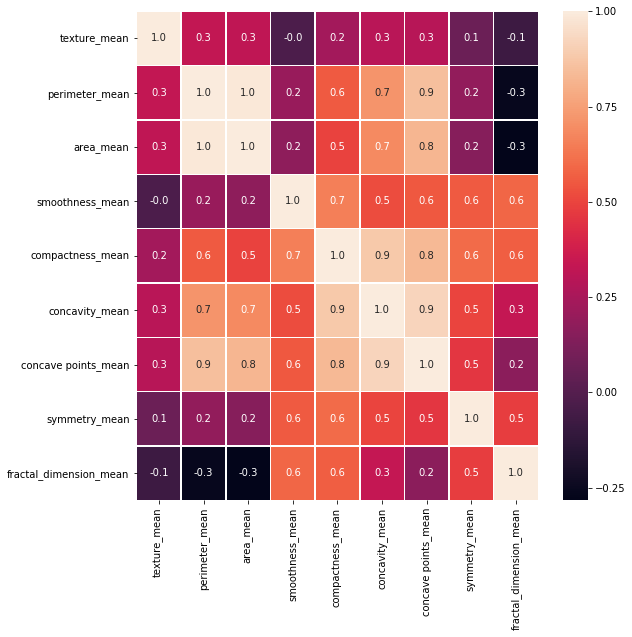

In [9]:
f, ax = plt.subplots(figsize=(x.shape[1], x.shape[1]))
sns.heatmap(x.corr(), annot=True, linewidths=.5, fmt= '.1f', ax=ax)

### PCA

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
basis = pca.fit(x_train)

In [11]:
x_train = basis.transform(x_train)
x_val = basis.transform(x_val)
x_test = basis.transform(x_test)

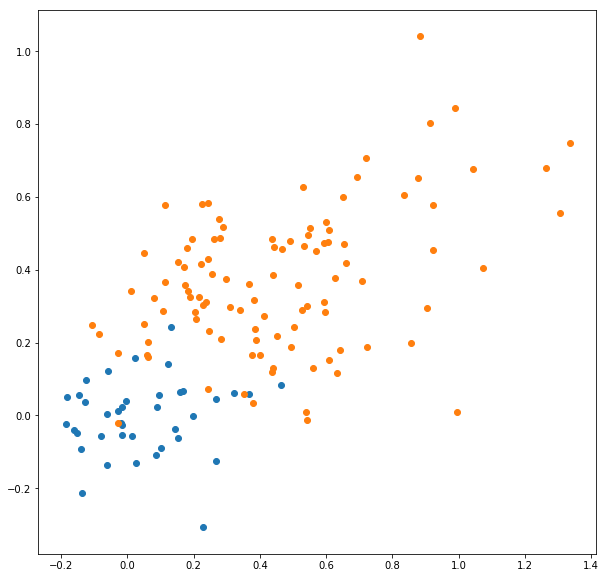

In [12]:
plt.figure(figsize=(10, 10))
plt.scatter(x_val[y_val[:, 1] == 'B', 0], x_val[y_val[:, 1] == 'B', 1])
plt.scatter(x_val[y_val[:, 1] == 'M', 0], x_val[y_val[:, 1] == 'M', 1])

## Ensemble of models

### Create an ensemble of models

In [13]:
import keras
from keras.layers import *
from keras.models import Model, Sequential
from keras.regularizers import l1_l2
from collections import defaultdict

c:\users\bearch\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [14]:
N_FEATURES = x_train.shape[1]

In [15]:
def create_base_model(input_size, n_hidden):
    i = Input((input_size, ))
    h = Dense(n_hidden, kernel_initializer='normal', use_bias=True, kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(i)
    h = LeakyReLU()(h)
    o = Dense(1)(h)
    return Model(i, o)

In [16]:
models = []
N_MODELS = 5
n_hidden_neurons = 64
for _ in range(N_MODELS):
    models.append(create_base_model(N_FEATURES, n_hidden_neurons))

In [17]:
models[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


### Train ensemble

In [18]:
def train(model, train_data, val_data, lr, batch_size, epochs=50, history=None):
    current_epoch = 0 if history is None else len(history.history['loss'])
    model.compile(
        loss='mean_squared_error',
        optimizer=keras.optimizers.Adam(lr=lr),
        metrics=['mse']
    )
    
    new_history = model.fit(
        train_data[0], train_data[1], epochs=current_epoch+epochs,
        batch_size=batch_size,
        validation_data=val_data,
        initial_epoch=current_epoch,
        verbose=1
    )
    
    if history is not None:
        for key in new_history.history:
            history.history[key].extend(new_history.history[key])
    else:
        history = new_history
    
    return history

In [19]:
histories = defaultdict(lambda: None)

In [20]:
for lr in [0.5, 0.1, 0.05, 0.01]:
    for i in range(N_MODELS):
        histories[i] = train(models[i], [x_train, y_train[:, 0]], (x_val, y_val[:, 0]), 
                             lr, batch_size=300, epochs=80, history=histories[i])

Train on 285 samples, validate on 142 samples
Epoch 1/80
285/285 [==============================] - 2s 8ms/step - loss: 150.6786 - mean_squared_error: 150.5614 - val_loss: 119.6611 - val_mean_squared_error: 118.3877
Epoch 2/80
285/285 [==============================] - 0s 17us/step - loss: 51.7795 - mean_squared_error: 50.5062 - val_loss: 60.5063 - val_mean_squared_error: 58.4714
Epoch 3/80
285/285 [==============================] - 0s 21us/step - loss: 67.4038 - mean_squared_error: 65.3689 - val_loss: 23.4124 - val_mean_squared_error: 21.1587
Epoch 4/80
285/285 [==============================] - 0s 17us/step - loss: 6.6977 - mean_squared_error: 4.4440 - val_loss: 18.8589 - val_mean_squared_error: 16.6882
Epoch 5/80
285/285 [==============================] - 0s 18us/step - loss: 23.4711 - mean_squared_error: 21.3004 - val_loss: 36.4455 - val_mean_squared_error: 34.4354
Epoch 6/80
285/285 [==============================] - 0s 21us/step - loss: 34.1233 - mean_squared_error: 32.1132 - val

Epoch 51/80
285/285 [==============================] - 0s 21us/step - loss: 0.8159 - mean_squared_error: 0.1935 - val_loss: 1.0373 - val_mean_squared_error: 0.4156
Epoch 52/80
285/285 [==============================] - 0s 21us/step - loss: 0.9507 - mean_squared_error: 0.3289 - val_loss: 0.8311 - val_mean_squared_error: 0.2290
Epoch 53/80
285/285 [==============================] - 0s 17us/step - loss: 0.8500 - mean_squared_error: 0.2478 - val_loss: 0.8976 - val_mean_squared_error: 0.3213
Epoch 54/80
285/285 [==============================] - 0s 21us/step - loss: 0.8153 - mean_squared_error: 0.2390 - val_loss: 1.0217 - val_mean_squared_error: 0.4530
Epoch 55/80
285/285 [==============================] - 0s 21us/step - loss: 0.8946 - mean_squared_error: 0.3260 - val_loss: 0.8217 - val_mean_squared_error: 0.2426
Epoch 56/80
285/285 [==============================] - 0s 21us/step - loss: 0.7874 - mean_squared_error: 0.2083 - val_loss: 0.8300 - val_mean_squared_error: 0.2406
Epoch 57/80
285/

Epoch 21/80
285/285 [==============================] - 0s 21us/step - loss: 4.7460 - mean_squared_error: 3.7789 - val_loss: 1.2877 - val_mean_squared_error: 0.3229
Epoch 22/80
285/285 [==============================] - 0s 21us/step - loss: 1.3265 - mean_squared_error: 0.3617 - val_loss: 6.1467 - val_mean_squared_error: 5.2000
Epoch 23/80
285/285 [==============================] - 0s 17us/step - loss: 5.4657 - mean_squared_error: 4.5190 - val_loss: 7.1513 - val_mean_squared_error: 6.2618
Epoch 24/80
285/285 [==============================] - 0s 14us/step - loss: 5.0611 - mean_squared_error: 4.1715 - val_loss: 2.5721 - val_mean_squared_error: 1.7318
Epoch 25/80
285/285 [==============================] - 0s 21us/step - loss: 1.4099 - mean_squared_error: 0.5696 - val_loss: 1.5705 - val_mean_squared_error: 0.7270
Epoch 26/80
285/285 [==============================] - 0s 17us/step - loss: 2.3934 - mean_squared_error: 1.5498 - val_loss: 2.9672 - val_mean_squared_error: 2.0969
Epoch 27/80
285/

Epoch 71/80
285/285 [==============================] - 0s 21us/step - loss: 0.8051 - mean_squared_error: 0.2056 - val_loss: 0.8043 - val_mean_squared_error: 0.1970
Epoch 72/80
285/285 [==============================] - 0s 17us/step - loss: 0.7838 - mean_squared_error: 0.1765 - val_loss: 0.8198 - val_mean_squared_error: 0.2245
Epoch 73/80
285/285 [==============================] - 0s 17us/step - loss: 0.7861 - mean_squared_error: 0.1907 - val_loss: 0.7905 - val_mean_squared_error: 0.2203
Epoch 74/80
285/285 [==============================] - 0s 17us/step - loss: 0.7887 - mean_squared_error: 0.2185 - val_loss: 0.7809 - val_mean_squared_error: 0.2357
Epoch 75/80
285/285 [==============================] - 0s 18us/step - loss: 0.7679 - mean_squared_error: 0.2227 - val_loss: 0.8415 - val_mean_squared_error: 0.2995
Epoch 76/80
285/285 [==============================] - 0s 17us/step - loss: 0.7574 - mean_squared_error: 0.2154 - val_loss: 0.8067 - val_mean_squared_error: 0.2520
Epoch 77/80
285/

Epoch 41/80
285/285 [==============================] - 0s 21us/step - loss: 1.2972 - mean_squared_error: 0.5620 - val_loss: 1.3679 - val_mean_squared_error: 0.6353
Epoch 42/80
285/285 [==============================] - 0s 18us/step - loss: 1.3881 - mean_squared_error: 0.6555 - val_loss: 0.9358 - val_mean_squared_error: 0.2245
Epoch 43/80
285/285 [==============================] - 0s 21us/step - loss: 0.9533 - mean_squared_error: 0.2420 - val_loss: 1.4689 - val_mean_squared_error: 0.7794
Epoch 44/80
285/285 [==============================] - 0s 25us/step - loss: 1.1220 - mean_squared_error: 0.4325 - val_loss: 1.7084 - val_mean_squared_error: 1.0391
Epoch 45/80
285/285 [==============================] - 0s 25us/step - loss: 1.2505 - mean_squared_error: 0.5813 - val_loss: 0.9917 - val_mean_squared_error: 0.3286
Epoch 46/80
285/285 [==============================] - 0s 28us/step - loss: 0.9165 - mean_squared_error: 0.2534 - val_loss: 1.0126 - val_mean_squared_error: 0.3463
Epoch 47/80
285/

Epoch 11/80
285/285 [==============================] - 0s 14us/step - loss: 2.5542 - mean_squared_error: 1.3210 - val_loss: 36.1318 - val_mean_squared_error: 35.0127
Epoch 12/80
285/285 [==============================] - 0s 14us/step - loss: 17.8311 - mean_squared_error: 16.7120 - val_loss: 3.0849 - val_mean_squared_error: 1.9961
Epoch 13/80
285/285 [==============================] - 0s 14us/step - loss: 1.9414 - mean_squared_error: 0.8526 - val_loss: 9.9616 - val_mean_squared_error: 8.8347
Epoch 14/80
285/285 [==============================] - 0s 17us/step - loss: 8.3037 - mean_squared_error: 7.1767 - val_loss: 9.8261 - val_mean_squared_error: 8.6496
Epoch 15/80
285/285 [==============================] - 0s 17us/step - loss: 8.8937 - mean_squared_error: 7.7172 - val_loss: 1.4081 - val_mean_squared_error: 0.1882
Epoch 16/80
285/285 [==============================] - 0s 18us/step - loss: 1.5133 - mean_squared_error: 0.2934 - val_loss: 8.9305 - val_mean_squared_error: 7.7206
Epoch 17/80


Epoch 61/80
285/285 [==============================] - 0s 17us/step - loss: 0.8124 - mean_squared_error: 0.2254 - val_loss: 0.7870 - val_mean_squared_error: 0.2090
Epoch 62/80
285/285 [==============================] - 0s 17us/step - loss: 0.7684 - mean_squared_error: 0.1904 - val_loss: 0.8559 - val_mean_squared_error: 0.2890
Epoch 63/80
285/285 [==============================] - 0s 21us/step - loss: 0.8082 - mean_squared_error: 0.2413 - val_loss: 0.8018 - val_mean_squared_error: 0.2415
Epoch 64/80
285/285 [==============================] - 0s 18us/step - loss: 0.7739 - mean_squared_error: 0.2136 - val_loss: 0.7537 - val_mean_squared_error: 0.1957
Epoch 65/80
285/285 [==============================] - 0s 17us/step - loss: 0.7541 - mean_squared_error: 0.1962 - val_loss: 0.7554 - val_mean_squared_error: 0.2026
Epoch 66/80
285/285 [==============================] - 0s 14us/step - loss: 0.7828 - mean_squared_error: 0.2300 - val_loss: 0.7624 - val_mean_squared_error: 0.2177
Epoch 67/80
285/

Epoch 31/80
285/285 [==============================] - 0s 18us/step - loss: 2.8790 - mean_squared_error: 2.0855 - val_loss: 1.5343 - val_mean_squared_error: 0.7160
Epoch 32/80
285/285 [==============================] - 0s 21us/step - loss: 1.6106 - mean_squared_error: 0.7924 - val_loss: 1.4937 - val_mean_squared_error: 0.6413
Epoch 33/80
285/285 [==============================] - 0s 18us/step - loss: 1.2429 - mean_squared_error: 0.3906 - val_loss: 1.8544 - val_mean_squared_error: 0.9930
Epoch 34/80
285/285 [==============================] - 0s 17us/step - loss: 2.3191 - mean_squared_error: 1.4577 - val_loss: 1.5623 - val_mean_squared_error: 0.7333
Epoch 35/80
285/285 [==============================] - 0s 14us/step - loss: 1.8417 - mean_squared_error: 1.0127 - val_loss: 1.0215 - val_mean_squared_error: 0.2271
Epoch 36/80
285/285 [==============================] - 0s 17us/step - loss: 1.0076 - mean_squared_error: 0.2132 - val_loss: 1.0917 - val_mean_squared_error: 0.3150
Epoch 37/80
285/

Train on 285 samples, validate on 142 samples
Epoch 81/160
285/285 [==============================] - 0s 1ms/step - loss: 0.6513 - mean_squared_error: 0.1688 - val_loss: 4.9728 - val_mean_squared_error: 4.5440
Epoch 82/160
285/285 [==============================] - 0s 17us/step - loss: 2.6280 - mean_squared_error: 2.1991 - val_loss: 6.0685 - val_mean_squared_error: 5.5849
Epoch 83/160
285/285 [==============================] - 0s 17us/step - loss: 3.1670 - mean_squared_error: 2.6834 - val_loss: 4.2355 - val_mean_squared_error: 3.7587
Epoch 84/160
285/285 [==============================] - 0s 17us/step - loss: 1.6331 - mean_squared_error: 1.1562 - val_loss: 0.7822 - val_mean_squared_error: 0.3467
Epoch 85/160
285/285 [==============================] - 0s 17us/step - loss: 0.8356 - mean_squared_error: 0.4002 - val_loss: 3.0373 - val_mean_squared_error: 2.6326
Epoch 86/160
285/285 [==============================] - 0s 17us/step - loss: 2.1237 - mean_squared_error: 1.7190 - val_loss: 2.083

Epoch 131/160
285/285 [==============================] - 0s 18us/step - loss: 0.5277 - mean_squared_error: 0.1707 - val_loss: 0.6437 - val_mean_squared_error: 0.2829
Epoch 132/160
285/285 [==============================] - 0s 17us/step - loss: 0.5186 - mean_squared_error: 0.1578 - val_loss: 0.7241 - val_mean_squared_error: 0.3630
Epoch 133/160
285/285 [==============================] - 0s 17us/step - loss: 0.5246 - mean_squared_error: 0.1635 - val_loss: 0.6970 - val_mean_squared_error: 0.3390
Epoch 134/160
285/285 [==============================] - 0s 17us/step - loss: 0.5238 - mean_squared_error: 0.1658 - val_loss: 0.6217 - val_mean_squared_error: 0.2690
Epoch 135/160
285/285 [==============================] - 0s 17us/step - loss: 0.5131 - mean_squared_error: 0.1603 - val_loss: 0.5834 - val_mean_squared_error: 0.2341
Epoch 136/160
285/285 [==============================] - 0s 21us/step - loss: 0.5153 - mean_squared_error: 0.1661 - val_loss: 0.5874 - val_mean_squared_error: 0.2384
Epoc

Epoch 101/160
285/285 [==============================] - 0s 21us/step - loss: 0.7501 - mean_squared_error: 0.2305 - val_loss: 0.9764 - val_mean_squared_error: 0.4806
Epoch 102/160
285/285 [==============================] - 0s 21us/step - loss: 0.9247 - mean_squared_error: 0.4288 - val_loss: 0.8874 - val_mean_squared_error: 0.4149
Epoch 103/160
285/285 [==============================] - 0s 17us/step - loss: 0.9514 - mean_squared_error: 0.4789 - val_loss: 0.7272 - val_mean_squared_error: 0.2691
Epoch 104/160
285/285 [==============================] - 0s 21us/step - loss: 0.7947 - mean_squared_error: 0.3366 - val_loss: 0.6877 - val_mean_squared_error: 0.2303
Epoch 105/160
285/285 [==============================] - 0s 21us/step - loss: 0.6743 - mean_squared_error: 0.2170 - val_loss: 0.7764 - val_mean_squared_error: 0.3091
Epoch 106/160
285/285 [==============================] - 0s 18us/step - loss: 0.7222 - mean_squared_error: 0.2550 - val_loss: 0.8421 - val_mean_squared_error: 0.3650
Epoc

Epoch 151/160
285/285 [==============================] - 0s 14us/step - loss: 0.5451 - mean_squared_error: 0.1642 - val_loss: 0.6307 - val_mean_squared_error: 0.2526
Epoch 152/160
285/285 [==============================] - 0s 14us/step - loss: 0.5430 - mean_squared_error: 0.1649 - val_loss: 0.6616 - val_mean_squared_error: 0.2850
Epoch 153/160
285/285 [==============================] - 0s 17us/step - loss: 0.5413 - mean_squared_error: 0.1647 - val_loss: 0.6529 - val_mean_squared_error: 0.2776
Epoch 154/160
285/285 [==============================] - 0s 14us/step - loss: 0.5385 - mean_squared_error: 0.1632 - val_loss: 0.6140 - val_mean_squared_error: 0.2434
Epoch 155/160
285/285 [==============================] - 0s 17us/step - loss: 0.5350 - mean_squared_error: 0.1644 - val_loss: 0.5947 - val_mean_squared_error: 0.2268
Epoch 156/160
285/285 [==============================] - 0s 14us/step - loss: 0.5349 - mean_squared_error: 0.1671 - val_loss: 0.6069 - val_mean_squared_error: 0.2371
Epoc

Epoch 121/160
285/285 [==============================] - 0s 21us/step - loss: 0.6140 - mean_squared_error: 0.1867 - val_loss: 0.7164 - val_mean_squared_error: 0.2867
Epoch 122/160
285/285 [==============================] - 0s 17us/step - loss: 0.5991 - mean_squared_error: 0.1694 - val_loss: 0.8348 - val_mean_squared_error: 0.4046
Epoch 123/160
285/285 [==============================] - 0s 17us/step - loss: 0.6366 - mean_squared_error: 0.2064 - val_loss: 0.8325 - val_mean_squared_error: 0.4080
Epoch 124/160
285/285 [==============================] - 0s 21us/step - loss: 0.6591 - mean_squared_error: 0.2346 - val_loss: 0.7168 - val_mean_squared_error: 0.2980
Epoch 125/160
285/285 [==============================] - 0s 17us/step - loss: 0.6322 - mean_squared_error: 0.2134 - val_loss: 0.6399 - val_mean_squared_error: 0.2238
Epoch 126/160
285/285 [==============================] - 0s 17us/step - loss: 0.5959 - mean_squared_error: 0.1798 - val_loss: 0.6257 - val_mean_squared_error: 0.2136
Epoc

Epoch 91/160
285/285 [==============================] - 0s 17us/step - loss: 1.5898 - mean_squared_error: 1.1173 - val_loss: 2.7241 - val_mean_squared_error: 2.2749
Epoch 92/160
285/285 [==============================] - 0s 17us/step - loss: 1.6070 - mean_squared_error: 1.1578 - val_loss: 0.9780 - val_mean_squared_error: 0.5601
Epoch 93/160
285/285 [==============================] - 0s 17us/step - loss: 0.8503 - mean_squared_error: 0.4325 - val_loss: 0.7173 - val_mean_squared_error: 0.3197
Epoch 94/160
285/285 [==============================] - 0s 17us/step - loss: 0.6310 - mean_squared_error: 0.2334 - val_loss: 1.5304 - val_mean_squared_error: 1.1410
Epoch 95/160
285/285 [==============================] - 0s 17us/step - loss: 1.0479 - mean_squared_error: 0.6585 - val_loss: 1.6710 - val_mean_squared_error: 1.2776
Epoch 96/160
285/285 [==============================] - 0s 14us/step - loss: 1.2473 - mean_squared_error: 0.8539 - val_loss: 1.0014 - val_mean_squared_error: 0.5923
Epoch 97/1

Epoch 141/160
285/285 [==============================] - 0s 17us/step - loss: 0.5231 - mean_squared_error: 0.1640 - val_loss: 0.6470 - val_mean_squared_error: 0.2918
Epoch 142/160
285/285 [==============================] - 0s 17us/step - loss: 0.5228 - mean_squared_error: 0.1676 - val_loss: 0.6298 - val_mean_squared_error: 0.2783
Epoch 143/160
285/285 [==============================] - 0s 18us/step - loss: 0.5163 - mean_squared_error: 0.1649 - val_loss: 0.6053 - val_mean_squared_error: 0.2560
Epoch 144/160
285/285 [==============================] - 0s 17us/step - loss: 0.5127 - mean_squared_error: 0.1633 - val_loss: 0.5892 - val_mean_squared_error: 0.2385
Epoch 145/160
285/285 [==============================] - 0s 14us/step - loss: 0.5149 - mean_squared_error: 0.1642 - val_loss: 0.5896 - val_mean_squared_error: 0.2367
Epoch 146/160
285/285 [==============================] - 0s 17us/step - loss: 0.5147 - mean_squared_error: 0.1618 - val_loss: 0.6150 - val_mean_squared_error: 0.2634
Epoc

Epoch 111/160
285/285 [==============================] - 0s 17us/step - loss: 0.7847 - mean_squared_error: 0.2893 - val_loss: 0.8118 - val_mean_squared_error: 0.3293
Epoch 112/160
285/285 [==============================] - 0s 17us/step - loss: 0.8929 - mean_squared_error: 0.4104 - val_loss: 0.7914 - val_mean_squared_error: 0.3156
Epoch 113/160
285/285 [==============================] - 0s 17us/step - loss: 0.8895 - mean_squared_error: 0.4138 - val_loss: 0.7340 - val_mean_squared_error: 0.2558
Epoch 114/160
285/285 [==============================] - 0s 17us/step - loss: 0.7838 - mean_squared_error: 0.3056 - val_loss: 0.6950 - val_mean_squared_error: 0.2095
Epoch 115/160
285/285 [==============================] - 0s 17us/step - loss: 0.6908 - mean_squared_error: 0.2053 - val_loss: 0.7204 - val_mean_squared_error: 0.2257
Epoch 116/160
285/285 [==============================] - 0s 18us/step - loss: 0.6945 - mean_squared_error: 0.1997 - val_loss: 0.7791 - val_mean_squared_error: 0.2772
Epoc

Train on 285 samples, validate on 142 samples
Epoch 161/240
285/285 [==============================] - 0s 2ms/step - loss: 0.4809 - mean_squared_error: 0.1573 - val_loss: 4.3806 - val_mean_squared_error: 4.0118
Epoch 162/240
285/285 [==============================] - 0s 17us/step - loss: 2.8739 - mean_squared_error: 2.5051 - val_loss: 0.9157 - val_mean_squared_error: 0.5631
Epoch 163/240
285/285 [==============================] - 0s 14us/step - loss: 0.5499 - mean_squared_error: 0.1973 - val_loss: 1.3430 - val_mean_squared_error: 1.0242
Epoch 164/240
285/285 [==============================] - 0s 14us/step - loss: 1.4725 - mean_squared_error: 1.1537 - val_loss: 2.2110 - val_mean_squared_error: 1.8846
Epoch 165/240
285/285 [==============================] - 0s 18us/step - loss: 2.0944 - mean_squared_error: 1.7680 - val_loss: 1.3389 - val_mean_squared_error: 0.9999
Epoch 166/240
285/285 [==============================] - 0s 14us/step - loss: 1.2699 - mean_squared_error: 0.9309 - val_loss:

285/285 [==============================] - 0s 18us/step - loss: 0.4738 - mean_squared_error: 0.1662 - val_loss: 0.6576 - val_mean_squared_error: 0.3530
Epoch 211/240
285/285 [==============================] - 0s 17us/step - loss: 0.4642 - mean_squared_error: 0.1597 - val_loss: 0.5881 - val_mean_squared_error: 0.2855
Epoch 212/240
285/285 [==============================] - 0s 14us/step - loss: 0.4588 - mean_squared_error: 0.1561 - val_loss: 0.5480 - val_mean_squared_error: 0.2452
Epoch 213/240
285/285 [==============================] - 0s 18us/step - loss: 0.4629 - mean_squared_error: 0.1602 - val_loss: 0.5461 - val_mean_squared_error: 0.2417
Epoch 214/240
285/285 [==============================] - 0s 17us/step - loss: 0.4676 - mean_squared_error: 0.1631 - val_loss: 0.5768 - val_mean_squared_error: 0.2719
Epoch 215/240
285/285 [==============================] - 0s 17us/step - loss: 0.4636 - mean_squared_error: 0.1587 - val_loss: 0.6334 - val_mean_squared_error: 0.3282
Epoch 216/240
285/

Epoch 180/240
285/285 [==============================] - 0s 14us/step - loss: 0.5348 - mean_squared_error: 0.1938 - val_loss: 1.0167 - val_mean_squared_error: 0.6797
Epoch 181/240
285/285 [==============================] - 0s 18us/step - loss: 0.5725 - mean_squared_error: 0.2356 - val_loss: 0.8729 - val_mean_squared_error: 0.5411
Epoch 182/240
285/285 [==============================] - 0s 17us/step - loss: 0.5402 - mean_squared_error: 0.2085 - val_loss: 0.6558 - val_mean_squared_error: 0.3284
Epoch 183/240
285/285 [==============================] - 0s 14us/step - loss: 0.4912 - mean_squared_error: 0.1638 - val_loss: 0.5458 - val_mean_squared_error: 0.2237
Epoch 184/240
285/285 [==============================] - 0s 17us/step - loss: 0.4934 - mean_squared_error: 0.1713 - val_loss: 0.5401 - val_mean_squared_error: 0.2220
Epoch 185/240
285/285 [==============================] - 0s 14us/step - loss: 0.5278 - mean_squared_error: 0.2097 - val_loss: 0.5421 - val_mean_squared_error: 0.2250
Epoc

Epoch 230/240
285/285 [==============================] - 0s 17us/step - loss: 0.4323 - mean_squared_error: 0.1516 - val_loss: 0.6009 - val_mean_squared_error: 0.3210
Epoch 231/240
285/285 [==============================] - 0s 17us/step - loss: 0.4311 - mean_squared_error: 0.1512 - val_loss: 0.5892 - val_mean_squared_error: 0.3108
Epoch 232/240
285/285 [==============================] - 0s 14us/step - loss: 0.4297 - mean_squared_error: 0.1513 - val_loss: 0.5940 - val_mean_squared_error: 0.3167
Epoch 233/240
285/285 [==============================] - 0s 17us/step - loss: 0.4286 - mean_squared_error: 0.1513 - val_loss: 0.6107 - val_mean_squared_error: 0.3347
Epoch 234/240
285/285 [==============================] - 0s 14us/step - loss: 0.4273 - mean_squared_error: 0.1512 - val_loss: 0.6188 - val_mean_squared_error: 0.3432
Epoch 235/240
285/285 [==============================] - 0s 17us/step - loss: 0.4274 - mean_squared_error: 0.1517 - val_loss: 0.6054 - val_mean_squared_error: 0.3312
Epoc

Epoch 200/240
285/285 [==============================] - 0s 17us/step - loss: 0.4932 - mean_squared_error: 0.1701 - val_loss: 0.5706 - val_mean_squared_error: 0.2472
Epoch 201/240
285/285 [==============================] - 0s 17us/step - loss: 0.4927 - mean_squared_error: 0.1693 - val_loss: 0.5992 - val_mean_squared_error: 0.2747
Epoch 202/240
285/285 [==============================] - 0s 17us/step - loss: 0.4829 - mean_squared_error: 0.1583 - val_loss: 0.6481 - val_mean_squared_error: 0.3225
Epoch 203/240
285/285 [==============================] - 0s 21us/step - loss: 0.4818 - mean_squared_error: 0.1563 - val_loss: 0.6784 - val_mean_squared_error: 0.3541
Epoch 204/240
285/285 [==============================] - 0s 17us/step - loss: 0.4865 - mean_squared_error: 0.1623 - val_loss: 0.6577 - val_mean_squared_error: 0.3355
Epoch 205/240
285/285 [==============================] - 0s 17us/step - loss: 0.4838 - mean_squared_error: 0.1616 - val_loss: 0.6094 - val_mean_squared_error: 0.2888
Epoc

Epoch 170/240
285/285 [==============================] - 0s 14us/step - loss: 1.1134 - mean_squared_error: 0.7972 - val_loss: 0.8333 - val_mean_squared_error: 0.5112
Epoch 171/240
285/285 [==============================] - 0s 17us/step - loss: 0.7444 - mean_squared_error: 0.4223 - val_loss: 0.5903 - val_mean_squared_error: 0.2609
Epoch 172/240
285/285 [==============================] - 0s 17us/step - loss: 0.4981 - mean_squared_error: 0.1687 - val_loss: 0.5941 - val_mean_squared_error: 0.2588
Epoch 173/240
285/285 [==============================] - 0s 17us/step - loss: 0.5948 - mean_squared_error: 0.2595 - val_loss: 0.6991 - val_mean_squared_error: 0.3588
Epoch 174/240
285/285 [==============================] - 0s 17us/step - loss: 0.8099 - mean_squared_error: 0.4695 - val_loss: 0.7110 - val_mean_squared_error: 0.3683
Epoch 175/240
285/285 [==============================] - 0s 21us/step - loss: 0.8412 - mean_squared_error: 0.4985 - val_loss: 0.6421 - val_mean_squared_error: 0.3001
Epoc

Epoch 220/240
285/285 [==============================] - 0s 17us/step - loss: 0.4593 - mean_squared_error: 0.1587 - val_loss: 0.5940 - val_mean_squared_error: 0.2957
Epoch 221/240
285/285 [==============================] - 0s 17us/step - loss: 0.4551 - mean_squared_error: 0.1567 - val_loss: 0.5710 - val_mean_squared_error: 0.2747
Epoch 222/240
285/285 [==============================] - 0s 18us/step - loss: 0.4515 - mean_squared_error: 0.1552 - val_loss: 0.5779 - val_mean_squared_error: 0.2814
Epoch 223/240
285/285 [==============================] - 0s 18us/step - loss: 0.4523 - mean_squared_error: 0.1558 - val_loss: 0.6049 - val_mean_squared_error: 0.3071
Epoch 224/240
285/285 [==============================] - 0s 17us/step - loss: 0.4543 - mean_squared_error: 0.1564 - val_loss: 0.6212 - val_mean_squared_error: 0.3226
Epoch 225/240
285/285 [==============================] - 0s 17us/step - loss: 0.4533 - mean_squared_error: 0.1548 - val_loss: 0.6105 - val_mean_squared_error: 0.3133
Epoc

Epoch 190/240
285/285 [==============================] - 0s 17us/step - loss: 0.5617 - mean_squared_error: 0.1928 - val_loss: 0.6478 - val_mean_squared_error: 0.2817
Epoch 191/240
285/285 [==============================] - 0s 21us/step - loss: 0.5384 - mean_squared_error: 0.1723 - val_loss: 0.5947 - val_mean_squared_error: 0.2310
Epoch 192/240
285/285 [==============================] - 0s 21us/step - loss: 0.5287 - mean_squared_error: 0.1649 - val_loss: 0.5781 - val_mean_squared_error: 0.2171
Epoch 193/240
285/285 [==============================] - 0s 21us/step - loss: 0.5403 - mean_squared_error: 0.1793 - val_loss: 0.5784 - val_mean_squared_error: 0.2186
Epoch 194/240
285/285 [==============================] - 0s 21us/step - loss: 0.5463 - mean_squared_error: 0.1866 - val_loss: 0.5834 - val_mean_squared_error: 0.2240
Epoch 195/240
285/285 [==============================] - 0s 17us/step - loss: 0.5330 - mean_squared_error: 0.1735 - val_loss: 0.6190 - val_mean_squared_error: 0.2592
Epoc

Epoch 240/240
285/285 [==============================] - 0s 17us/step - loss: 0.4613 - mean_squared_error: 0.1541 - val_loss: 0.6290 - val_mean_squared_error: 0.3224
Train on 285 samples, validate on 142 samples
Epoch 241/320
285/285 [==============================] - 1s 2ms/step - loss: 0.4454 - mean_squared_error: 0.1517 - val_loss: 0.7629 - val_mean_squared_error: 0.4799
Epoch 242/320
285/285 [==============================] - 0s 21us/step - loss: 0.5260 - mean_squared_error: 0.2430 - val_loss: 0.6017 - val_mean_squared_error: 0.3161
Epoch 243/320
285/285 [==============================] - 0s 21us/step - loss: 0.4419 - mean_squared_error: 0.1563 - val_loss: 0.5672 - val_mean_squared_error: 0.2772
Epoch 244/320
285/285 [==============================] - 0s 17us/step - loss: 0.4775 - mean_squared_error: 0.1875 - val_loss: 0.5784 - val_mean_squared_error: 0.2852
Epoch 245/320
285/285 [==============================] - 0s 18us/step - loss: 0.4978 - mean_squared_error: 0.2045 - val_loss:

Epoch 290/320
285/285 [==============================] - 0s 14us/step - loss: 0.4214 - mean_squared_error: 0.1512 - val_loss: 0.5941 - val_mean_squared_error: 0.3240
Epoch 291/320
285/285 [==============================] - 0s 17us/step - loss: 0.4213 - mean_squared_error: 0.1512 - val_loss: 0.5920 - val_mean_squared_error: 0.3220
Epoch 292/320
285/285 [==============================] - 0s 14us/step - loss: 0.4213 - mean_squared_error: 0.1513 - val_loss: 0.5962 - val_mean_squared_error: 0.3266
Epoch 293/320
285/285 [==============================] - 0s 18us/step - loss: 0.4207 - mean_squared_error: 0.1511 - val_loss: 0.6045 - val_mean_squared_error: 0.3354
Epoch 294/320
285/285 [==============================] - 0s 17us/step - loss: 0.4199 - mean_squared_error: 0.1507 - val_loss: 0.6139 - val_mean_squared_error: 0.3453
Epoch 295/320
285/285 [==============================] - 0s 21us/step - loss: 0.4193 - mean_squared_error: 0.1507 - val_loss: 0.6219 - val_mean_squared_error: 0.3535
Epoc

Epoch 260/320
285/285 [==============================] - 0s 21us/step - loss: 0.4046 - mean_squared_error: 0.1495 - val_loss: 0.6485 - val_mean_squared_error: 0.3949
Epoch 261/320
285/285 [==============================] - 0s 18us/step - loss: 0.4062 - mean_squared_error: 0.1526 - val_loss: 0.6328 - val_mean_squared_error: 0.3807
Epoch 262/320
285/285 [==============================] - 0s 17us/step - loss: 0.4051 - mean_squared_error: 0.1530 - val_loss: 0.6033 - val_mean_squared_error: 0.3526
Epoch 263/320
285/285 [==============================] - 0s 18us/step - loss: 0.4023 - mean_squared_error: 0.1516 - val_loss: 0.5767 - val_mean_squared_error: 0.3270
Epoch 264/320
285/285 [==============================] - 0s 17us/step - loss: 0.4012 - mean_squared_error: 0.1515 - val_loss: 0.5653 - val_mean_squared_error: 0.3156
Epoch 265/320
285/285 [==============================] - 0s 17us/step - loss: 0.4024 - mean_squared_error: 0.1526 - val_loss: 0.5718 - val_mean_squared_error: 0.3216
Epoc

Epoch 310/320
285/285 [==============================] - 0s 17us/step - loss: 0.3760 - mean_squared_error: 0.1472 - val_loss: 0.6165 - val_mean_squared_error: 0.3883
Epoch 311/320
285/285 [==============================] - 0s 17us/step - loss: 0.3755 - mean_squared_error: 0.1472 - val_loss: 0.6113 - val_mean_squared_error: 0.3835
Epoch 312/320
285/285 [==============================] - 0s 21us/step - loss: 0.3749 - mean_squared_error: 0.1471 - val_loss: 0.6041 - val_mean_squared_error: 0.3766
Epoch 313/320
285/285 [==============================] - 0s 21us/step - loss: 0.3745 - mean_squared_error: 0.1470 - val_loss: 0.5980 - val_mean_squared_error: 0.3710
Epoch 314/320
285/285 [==============================] - 0s 18us/step - loss: 0.3740 - mean_squared_error: 0.1469 - val_loss: 0.5954 - val_mean_squared_error: 0.3687
Epoch 315/320
285/285 [==============================] - 0s 17us/step - loss: 0.3735 - mean_squared_error: 0.1469 - val_loss: 0.5959 - val_mean_squared_error: 0.3698
Epoc

Epoch 280/320
285/285 [==============================] - 0s 17us/step - loss: 0.4213 - mean_squared_error: 0.1518 - val_loss: 0.6238 - val_mean_squared_error: 0.3550
Epoch 281/320
285/285 [==============================] - 0s 17us/step - loss: 0.4202 - mean_squared_error: 0.1514 - val_loss: 0.6068 - val_mean_squared_error: 0.3388
Epoch 282/320
285/285 [==============================] - 0s 21us/step - loss: 0.4194 - mean_squared_error: 0.1514 - val_loss: 0.5919 - val_mean_squared_error: 0.3243
Epoch 283/320
285/285 [==============================] - 0s 14us/step - loss: 0.4196 - mean_squared_error: 0.1519 - val_loss: 0.5789 - val_mean_squared_error: 0.3112
Epoch 284/320
285/285 [==============================] - 0s 18us/step - loss: 0.4198 - mean_squared_error: 0.1521 - val_loss: 0.5784 - val_mean_squared_error: 0.3110
Epoch 285/320
285/285 [==============================] - 0s 18us/step - loss: 0.4189 - mean_squared_error: 0.1515 - val_loss: 0.5898 - val_mean_squared_error: 0.3229
Epoc

Epoch 250/320
285/285 [==============================] - 0s 17us/step - loss: 0.4465 - mean_squared_error: 0.1699 - val_loss: 0.6004 - val_mean_squared_error: 0.3243
Epoch 251/320
285/285 [==============================] - 0s 17us/step - loss: 0.4340 - mean_squared_error: 0.1579 - val_loss: 0.5712 - val_mean_squared_error: 0.2949
Epoch 252/320
285/285 [==============================] - 0s 18us/step - loss: 0.4313 - mean_squared_error: 0.1550 - val_loss: 0.5590 - val_mean_squared_error: 0.2820
Epoch 253/320
285/285 [==============================] - 0s 17us/step - loss: 0.4379 - mean_squared_error: 0.1610 - val_loss: 0.5626 - val_mean_squared_error: 0.2848
Epoch 254/320
285/285 [==============================] - 0s 21us/step - loss: 0.4414 - mean_squared_error: 0.1636 - val_loss: 0.5781 - val_mean_squared_error: 0.2997
Epoch 255/320
285/285 [==============================] - 0s 17us/step - loss: 0.4365 - mean_squared_error: 0.1580 - val_loss: 0.6018 - val_mean_squared_error: 0.3236
Epoc

Epoch 300/320
285/285 [==============================] - 0s 17us/step - loss: 0.4078 - mean_squared_error: 0.1499 - val_loss: 0.6063 - val_mean_squared_error: 0.3492
Epoch 301/320
285/285 [==============================] - 0s 17us/step - loss: 0.4071 - mean_squared_error: 0.1500 - val_loss: 0.6045 - val_mean_squared_error: 0.3481
Epoch 302/320
285/285 [==============================] - 0s 14us/step - loss: 0.4066 - mean_squared_error: 0.1502 - val_loss: 0.6004 - val_mean_squared_error: 0.3446
Epoch 303/320
285/285 [==============================] - 0s 17us/step - loss: 0.4061 - mean_squared_error: 0.1504 - val_loss: 0.5968 - val_mean_squared_error: 0.3415
Epoch 304/320
285/285 [==============================] - 0s 14us/step - loss: 0.4056 - mean_squared_error: 0.1503 - val_loss: 0.5974 - val_mean_squared_error: 0.3423
Epoch 305/320
285/285 [==============================] - 0s 17us/step - loss: 0.4052 - mean_squared_error: 0.1501 - val_loss: 0.6009 - val_mean_squared_error: 0.3460
Epoc

Epoch 270/320
285/285 [==============================] - 0s 17us/step - loss: 0.4322 - mean_squared_error: 0.1551 - val_loss: 0.5649 - val_mean_squared_error: 0.2886
Epoch 271/320
285/285 [==============================] - 0s 17us/step - loss: 0.4305 - mean_squared_error: 0.1543 - val_loss: 0.5602 - val_mean_squared_error: 0.2839
Epoch 272/320
285/285 [==============================] - 0s 17us/step - loss: 0.4296 - mean_squared_error: 0.1533 - val_loss: 0.5581 - val_mean_squared_error: 0.2816
Epoch 273/320
285/285 [==============================] - 0s 21us/step - loss: 0.4296 - mean_squared_error: 0.1531 - val_loss: 0.5572 - val_mean_squared_error: 0.2808
Epoch 274/320
285/285 [==============================] - 0s 21us/step - loss: 0.4290 - mean_squared_error: 0.1526 - val_loss: 0.5563 - val_mean_squared_error: 0.2807
Epoch 275/320
285/285 [==============================] - 0s 21us/step - loss: 0.4273 - mean_squared_error: 0.1517 - val_loss: 0.5561 - val_mean_squared_error: 0.2814
Epoc

Epoch 320/320
285/285 [==============================] - 0s 17us/step - loss: 0.3901 - mean_squared_error: 0.1485 - val_loss: 0.4778 - val_mean_squared_error: 0.2368


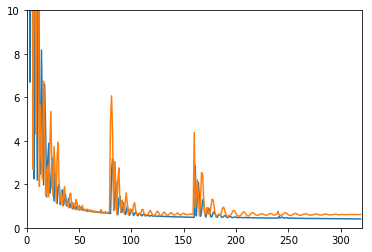

In [21]:
plt.plot(histories[0].history['loss'])
plt.plot(histories[0].history['val_loss'])
plt.axis([0, len(histories[0].history['loss']), 0, 10])
plt.show()

## Predict target feature using ensemble

In [22]:
y_train_preds = []
y_val_preds = []
y_test_preds = []

for model in models:
    y_train_preds.append(model.predict(x_train))
    y_val_preds.append(model.predict(x_val))
    y_test_preds.append(model.predict(x_test))

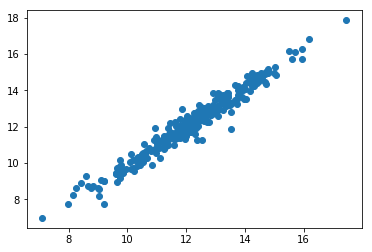

In [23]:
plt.scatter(np.mean(y_train_preds, axis=0), y_train[:, 0])
plt.show()

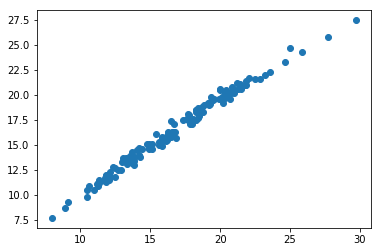

In [24]:
plt.scatter(np.mean(y_val_preds, axis=0), y_val[:, 0])
plt.show()

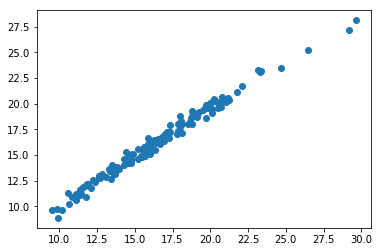

In [25]:
plt.scatter(np.mean(y_test_preds, axis=0), y_test[:, 0])
plt.show()

## Use ensemble variance to predict diagnosis 

In [26]:
y_train_preds_var = np.var(y_train_preds, axis=0)
y_val_preds_var = np.var(y_val_preds, axis=0)
y_test_preds_var = np.var(y_test_preds, axis=0)

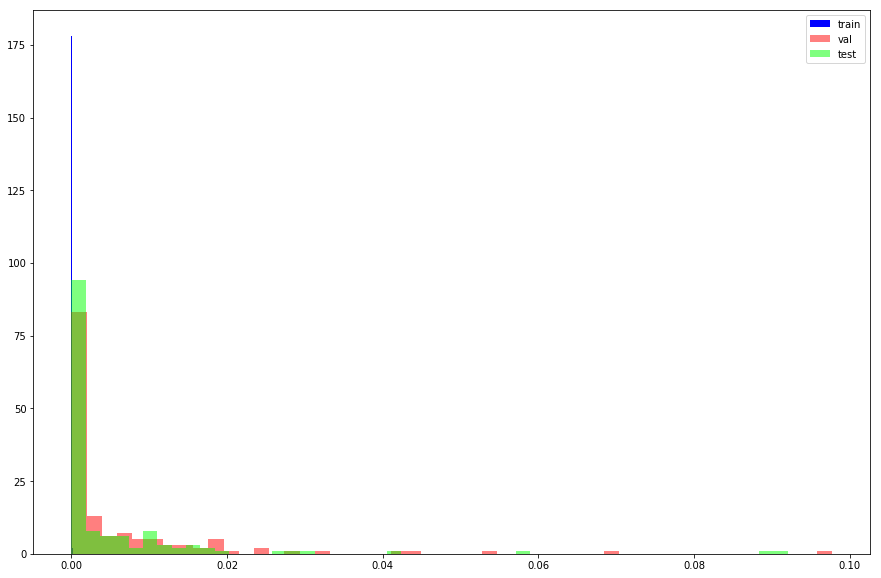

In [27]:
plt.figure(figsize=(15, 10))
plt.hist(y_train_preds_var, color='b',  bins=50, label='train')
plt.hist(y_val_preds_var, fc=(1, 0, 0, 0.5), bins=50, label='val')
plt.hist(y_test_preds_var, fc=(0, 1, 0, 0.5), bins=50, label='test')
plt.legend()
plt.show()

### Select variance threshold

In [28]:
def predict(y_preds_var, y, threshold):
    predictions = []
    
    for pred in y_preds_var:
            predictions.append(pred > threshold) 
    
    return predictions
    
def weighted_accuracy(y_preds_var, y, threshold):
    accs = []
    weights = []
    
    _, counts = np.unique(y[:, 1], return_counts=True)
    try:
        weight_b = counts[1]
        weight_m = counts[0]
    except:
        weight_b = 1
        weight_m = 1
    
    for i, pred in enumerate(y_preds_var):
        if y[i, 1] == 'B':
            accs.append(pred < threshold)
            weights.append(weight_b) 
        elif y[i, 1] == 'M':
            accs.append(pred > threshold)
            weights.append(weight_m)

    return np.average(accs, axis=0, weights=weights)[0] * 100

In [39]:
thresholds = np.linspace(0, 100, 1000) *  y_train_preds_var.mean()
accs = []

for thr in thresholds:
    accs.append(weighted_accuracy(y_val_preds_var, y_val, thr))

threshold = thresholds[np.argmax(accs)]

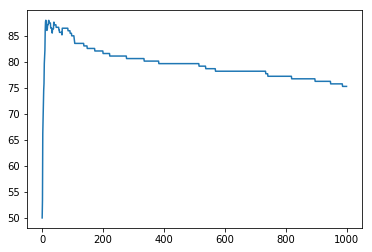

In [40]:
plt.plot(accs)
plt.show()

## Evaluation Metrics

In [41]:
print('Training Accuracy: %.1f%%' % weighted_accuracy(y_train_preds_var, y_train, threshold))

Training Accuracy: 76.5%


In [42]:
print('Validation Accuracy: %.1f%%' % weighted_accuracy(y_val_preds_var, y_val, threshold))

Validation Accuracy: 87.9%


In [43]:
print('Test Accuracy: %.1f%%' % weighted_accuracy(y_test_preds_var, y_test, threshold))

Test Accuracy: 72.8%


### Confusion Matrix

In [44]:
from sklearn.metrics import confusion_matrix

#### Validation

In [45]:
y_val_pred = predict(y_val_preds_var, y_val, threshold)
y_val_bool = [True if o == 'M' else False for o in y_val[:, 1]]

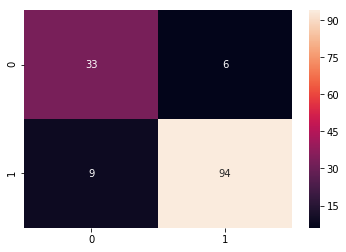

In [46]:
sns.heatmap(confusion_matrix(y_val_bool, y_val_pred), annot=True)

#### Test

In [47]:
y_test_pred = predict(y_test_preds_var, y_test, threshold)
y_test_bool = [True if o == 'M' else False for o in y_test[:, 1]]

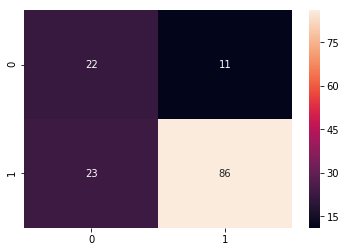

In [48]:
sns.heatmap(confusion_matrix(y_test_bool, y_test_pred), annot=True)

Done!